## Import Necessary Packages

In [15]:
import pickle
import warnings
import numpy as np
import pandas as pd
import proplot as pplt
from matplotlib.lines import Line2D
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
pplt.rc['figure.dpi'] = 100
warnings.filterwarnings('ignore')

## Load Results

In [16]:
FILEDIR = '/global/cfs/cdirs/m4334/sferrett/monsoon-sr/data/'

with open(f'{FILEDIR}/results/baseline_results.pkl','rb') as file:
    baseresults = pickle.load(file)
with open(f'{FILEDIR}/results/v1_results.pkl','rb') as file:
    mlpresults = pickle.load(file)

xtrue = pd.read_parquet(f'{FILEDIR}/processed/Xtest.parquet')['bl']
ytrue = pd.read_parquet(f'{FILEDIR}/processed/ytest.parquet')['pr']

## Functions

In [17]:
def create_log_rain_bins(binspacing=0.08,minleftedge=0.001,maxcenter=1000):
    firstcenter = minleftedge/(1-binspacing/2)
    center      = firstcenter
    bincenters  = []
    binwidths   = []
    while center<=maxcenter:
        width = center*(binspacing)
        bincenters.append(center)
        binwidths.append(width)
        center  = center*(1+binspacing)
    bincenters  = np.array(bincenters)
    binwidths   = np.array(binwidths)
    binedges    = np.zeros(len(bincenters)+1)
    binedges[0] = bincenters[0]-binwidths[0]/2
    for i in range(len(bincenters)):
        binedges[i+1] = bincenters[i]+binwidths[i]/2
    return bincenters,binwidths,binedges

def get_hist(ytrue,ypred):
    nonzeromask  = (ytrue>0)&(ypred>0)
    ytruenonzero = ytrue[nonzeromask]
    yprednonzero = ypred[nonzeromask]
    _,_,binedges = create_log_rain_bins()
    counts,_,_   = np.histogram2d(ytruenonzero,yprednonzero,bins=[binedges,binedges])
    countsmasked = np.ma.masked_where(counts==0,counts)
    return countsmasked,binedges

def get_amount_dist(ydata,drythresh=0.25):
    drydays = ydata<drythresh
    wetdays = ydata[~drydays]
    totalpr = np.sum(wetdays)
    bincenters,binwidths,binedges = create_log_rain_bins()
    counts,_  = np.histogram(wetdays,bins=binedges)
    amtperbin = np.zeros_like(counts)
    for i in range(len(bincenters)):
        inbin = (wetdays>=binedges[i])&(wetdays<binedges[i+1])
        if np.any(inbin):
            amtperbin[i] = np.sum(wetdays[inbin])
    amtcontrib = amtperbin/totalpr
    return {
        'bins':bincenters,
        'widths':binwidths,
        'amtcontrib':amtcontrib,
        'amtperbin':amtperbin}

In [18]:
def hellinger_distance(p,q):
    minlength = min(len(p),len(q))
    p = p[:minlength]
    q = q[:minlength]
    p = p/np.sum(p)
    q = q/np.sum(q)
    return np.sqrt(0.5*np.sum((np.sqrt(p)-np.sqrt(q))**2))

def get_metrics(allmodels,prthresh=0):
    metricsdata = []
    for modelname,results in allmodels.items():
        ytruemodel = results['ytrue']
        ypredmodel = results['ypred']
        r2score = r2_score(ytruemodel,ypredmodel)
        mae  = mean_absolute_error(ytruemodel,ypredmodel)
        mse  = mean_squared_error(ytruemodel,ypredmodel)
        bias = np.mean(ypredmodel-ytruemodel) 
        prthresh   = 0.25
        trueevents = ytruemodel>prthresh
        predevents = ypredmodel>prthresh
        hitrate    = np.sum(trueevents&predevents)/np.sum(trueevents) if np.sum(trueevents)>0 else 0
        far        = np.sum(predevents&~trueevents)/np.sum(predevents) if np.sum(predevents)>0 else 0
        _,_,binedges = create_log_rain_bins()
        histtrue,_ = np.histogram(ytruemodel,bins=binedges,density=True)
        histpred,_ = np.histogram(ypredmodel,bins=binedges,density=True)
        hellinger  = hellinger_distance(histtrue,histpred)
        metricsdata.append({
            'name':modelname,
            'description':results['description'],
            'r2':r2score,
            'mae':mae,
            'mse':mse,
            'bias':bias,
            'hitrate':hitrate,
            'far':far,
            'hellinger':hellinger,
             'nparams':results['nparams']})
    return pd.DataFrame(metricsdata)

def get_model_color(modelname):
    if modelname.startswith('bw_'):
        return 'red6'
    elif 'mae' in modelname:
        if '_log' in modelname:
            return 'yellow2'  
        else:
            return 'yellow6'
    elif 'mse' in modelname:
        if '_log' in modelname:
            return 'blue2'
        else:
            return 'blue6'
    else:
        return 'gray'

def get_model_marker(modelname):
    if 'shallow' in modelname or 'bw_0.1' in modelname:
        return 'o'
    elif 'medium' in modelname or 'bw_0.01' in modelname:
        return 's' 
    elif 'deep' in modelname or 'bw_0.001' in modelname:
        return '^'  
    else:
        return 'D'

## Clean Precipitation

In [19]:
allmodels = {}

for modelname,results in baseresults.items():
    ypredvalues = results['ypred']
    ytruevalues = ytrue.values
    validmask = np.isfinite(ypredvalues)&np.isfinite(ytruevalues)
    allmodels[modelname] = {
        'description':results['description'],
        'ypred':ypredvalues[validmask],
        'ytrue':ytruevalues[validmask],
        'nparams':results['nparams']}

for modelname,results in mlpresults.items():
    ypredvalues = results['ypred'].squeeze()
    ytruevalues = ytrue.values
    validmask = np.isfinite(ypredvalues)&np.isfinite(ytruevalues)
    allmodels[modelname] = {
        'description':results['description'],
        'ypred':ypredvalues[validmask],
        'ytrue':ytruevalues[validmask],
        'nparams':results['nparams']}

## Model Training and Validation Losses

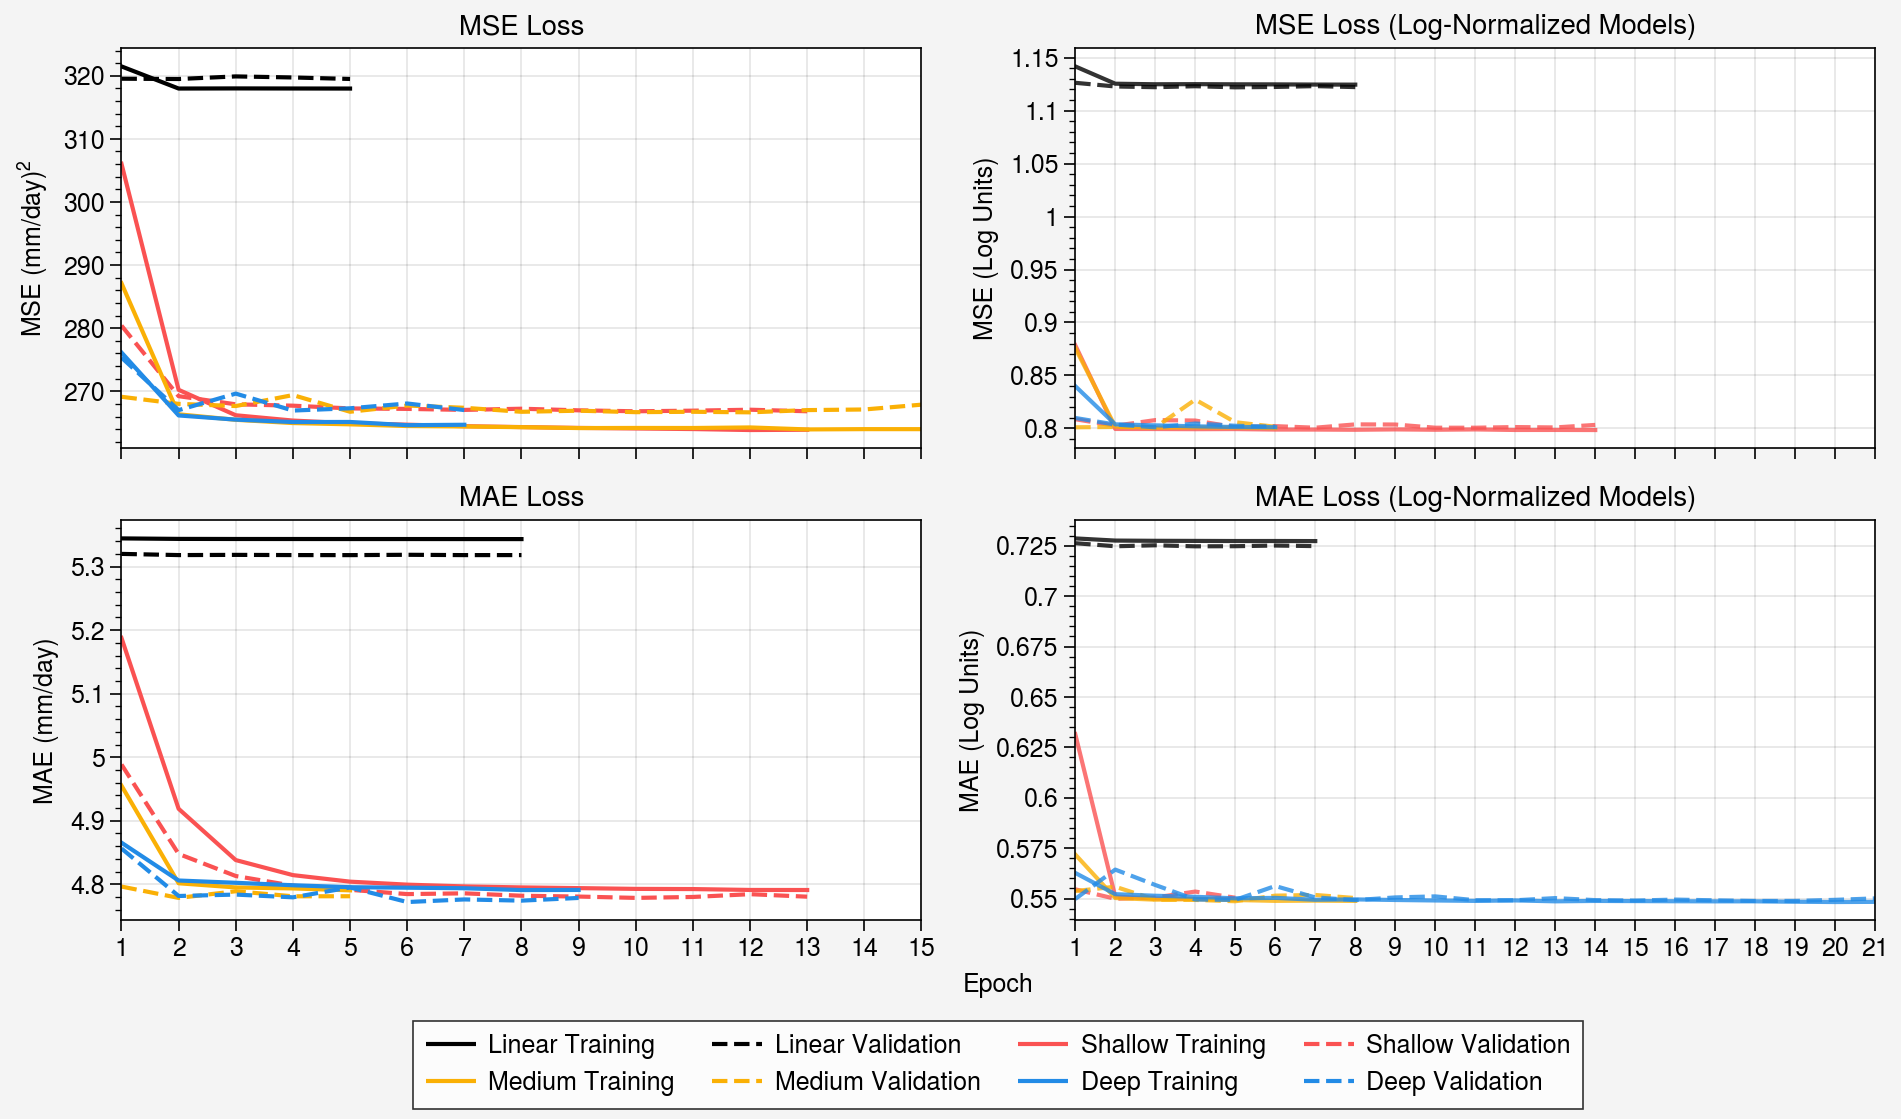

In [20]:
fig,axs = pplt.subplots(nrows=2,ncols=2,refwidth=4,refheight=2,sharex=True,sharey=False)
axs.format(xlabel='Epoch',xticks=1,xminorticks=1)
axs[0,0].format(title='MSE Loss',ylabel='MSE (mm/day)$^2$')
axs[0,1].format(title='MSE Loss (Log-Normalized Models)',ylabel='MSE (Log Units)')
axs[1,0].format(title='MAE Loss',ylabel='MAE (mm/day)')
axs[1,1].format(title='MAE Loss (Log-Normalized Models)',ylabel='MAE (Log Units)')

colors = {'linear':'k','shallow':'red6','medium':'yellow6','deep':'blue6'}

for model in ['lin_mse','mse_shallow','mse_medium','mse_deep']:
    modeltype   = 'linear' if 'lin' in model else model.split('_')[1]
    description = modeltype.capitalize() if modeltype!='linear' else 'Linear'
    trainlosses = mlpresults[model]['trainlosses']
    validlosses = mlpresults[model]['validlosses']
    epochs = range(1,len(trainlosses)+1)
    axs[0,0].plot(epochs,trainlosses,color=colors[modeltype],linestyle='-',label=f'{description} Training')
    axs[0,0].plot(epochs,validlosses,color=colors[modeltype],linestyle='--',label=f'{description} Validation')

for model in ['lin_mse_log','mse_shallow_log','mse_medium_log','mse_deep_log']:
    modeltype   = 'linear' if 'lin' in model else model.split('_')[1]
    description = modeltype.capitalize() if modeltype!='linear' else 'Linear'
    trainlosses = mlpresults[model]['trainlosses']
    validlosses = mlpresults[model]['validlosses']
    epochs = range(1,len(trainlosses)+1)
    axs[0,1].plot(epochs,trainlosses,color=colors[modeltype],linestyle='-',alpha=0.8)
    axs[0,1].plot(epochs,validlosses,color=colors[modeltype],linestyle='--',alpha=0.8)

for model in ['lin_mae','mae_shallow','mae_medium','mae_deep']:
    modeltype   = 'linear' if 'lin' in model else model.split('_')[1]
    description = modeltype.capitalize() if modeltype!='linear' else 'Linear'
    trainlosses = mlpresults[model]['trainlosses']
    validlosses = mlpresults[model]['validlosses']
    epochs = range(1,len(trainlosses)+1)
    axs[1,0].plot(epochs,trainlosses,color=colors[modeltype],linestyle='-')
    axs[1,0].plot(epochs,validlosses,color=colors[modeltype],linestyle='--')

for model in ['lin_mae_log','mae_shallow_log','mae_medium_log','mae_deep_log']:
    modeltype   = 'linear' if 'lin' in model else model.split('_')[1]
    description = modeltype.capitalize() if modeltype!='linear' else 'Linear'
    trainlosses = mlpresults[model]['trainlosses']
    validlosses = mlpresults[model]['validlosses']
    epochs = range(1,len(trainlosses)+1)
    axs[1,1].plot(epochs,trainlosses,color=colors[modeltype],linestyle='-',alpha=0.8)
    axs[1,1].plot(epochs,validlosses,color=colors[modeltype],linestyle='--',alpha=0.8)

fig.legend(loc='b',ncols=4)

pplt.show()

## Plot Actual vs. Predicted Precipitation

In [21]:
allvalues = []
allvalues.extend(ytrue.values)
for modelname,results in baseresults.items():
    allvalues.extend(results['ypred'])
for modelname,results in mlpresults.items():
    allvalues.extend(results['ypred'].squeeze())
    
allvalues = np.array(np.array(allvalues))
allvalues = allvalues[np.isfinite(allvalues)]
    
globalmin = np.min(allvalues) 
globalmax = np.max(allvalues)
print(f'Precipitation ranges from {globalmin} to {globalmax:.2f} mm/day')

Precipitation ranges from -0.8913546204566956 to 876.11 mm/day


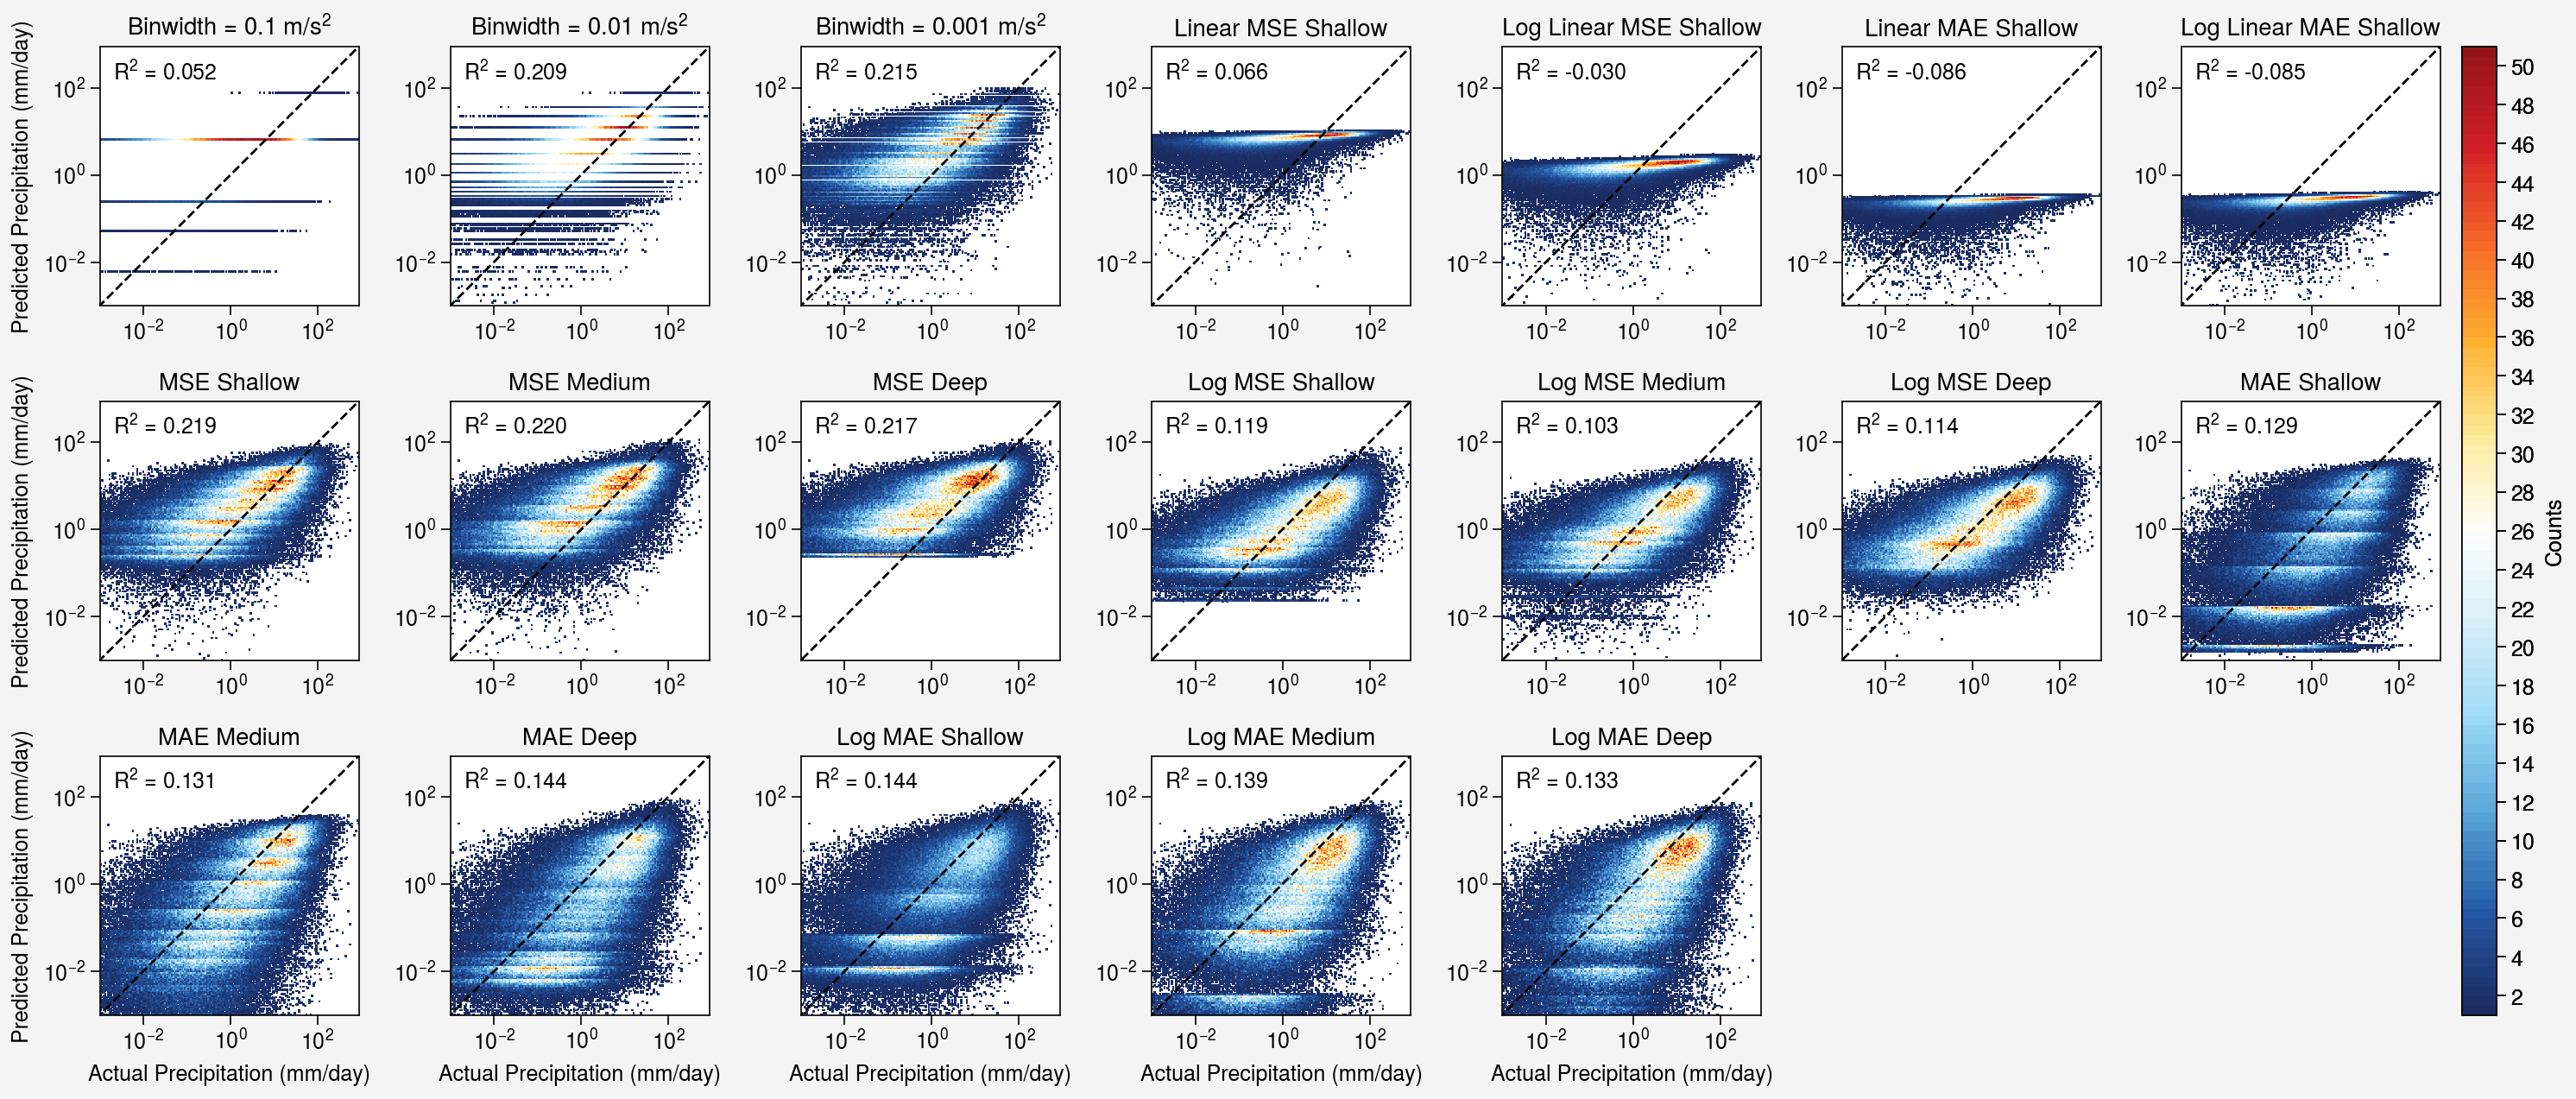

In [34]:
ticks   = [1e-4,1e-2,1e0,1e2]
ncols   = 7
nrows   = (len(allmodels)+ncols-1)//ncols
fig,axs = pplt.subplots(nrows=nrows,ncols=ncols,refwidth=1.5,share=False)

for i,(modelname,results) in enumerate(allmodels.items()):
    row = i//ncols
    col = i%ncols
    ytruemodel = results['ytrue']
    ypredmodel = results['ypred']
    r2score    = r2_score(ytruemodel,ypredmodel)
    hist,binedges = get_hist(ytruemodel,ypredmodel)
    im = axs[row,col].pcolormesh(binedges,binedges,hist.T,cmap='ColdHot',levels=100)
    axs[row,col].plot([globalmin,globalmax],[globalmin,globalmax],'k--',linewidth=1)
    axs[row,col].text(0.05,0.95,f'R$^2$ = {r2score:.3f}',transform=axs[row,col].transAxes,va='top',ha='left')
    axs[row,col].format(title=results['description'])
for i in range(len(allmodels),nrows*ncols):
    row = i//ncols
    col = i%ncols
    axs[row,col].axis('off')

axs.format(xscale='log',xformatter='log',xlim=[globalmin,globalmax],xticks=ticks,xminorticks='none',
           yscale='log',yformatter='log',ylim=[globalmin,globalmax],yticks=ticks,yminorticks='none')
axs[:,0].format(ylabel='Predicted Precipitation (mm/day)')
axs[-1,:].format(xlabel='Actual Precipitation (mm/day)')

fig.colorbar(im,loc='r',label='Counts',ticks=2)
pplt.show()

## Plot Actual vs. Predicted Amount Distribution

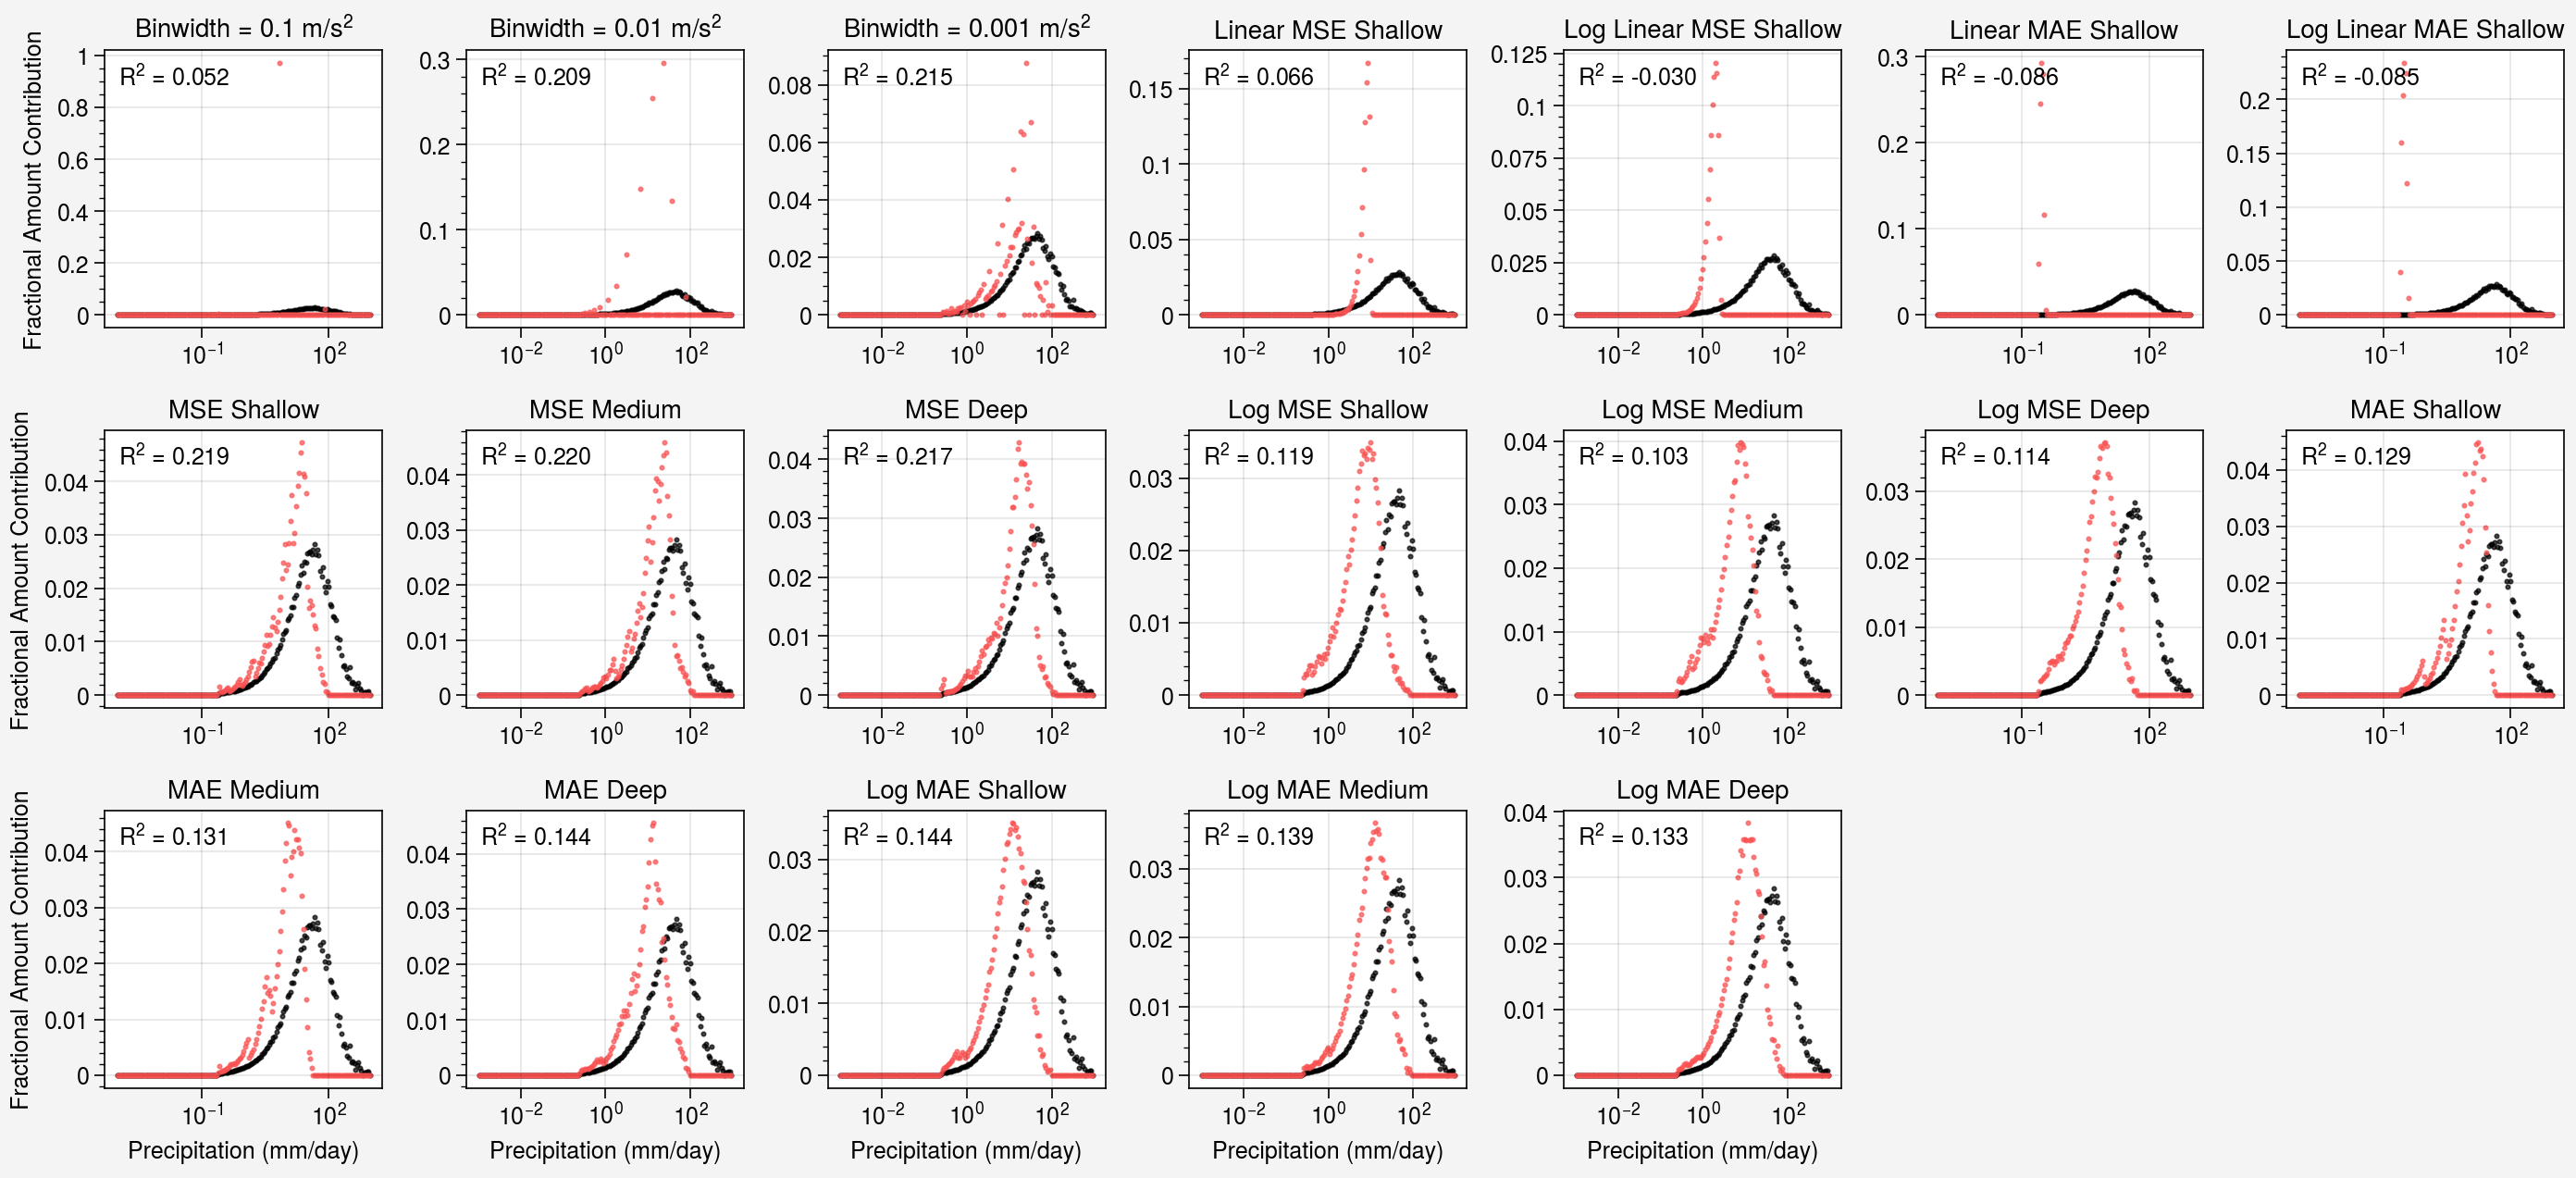

In [37]:
ticks   = [1e-4,1e-2,1e0,1e2]
ncols   = 7
nrows   = (len(allmodels)+ncols-1)//ncols
fig,axs = pplt.subplots(nrows=nrows,ncols=ncols,refwidth=1.5,share=False)

for i,(modelname,results) in enumerate(allmodels.items()):
    row = i//ncols
    col = i%ncols
    ytruemodel = results['ytrue']
    ypredmodel = results['ypred']
    r2score    = r2_score(ytruemodel,ypredmodel)
    disttrue   = get_amount_dist(ytruemodel)
    distpred   = get_amount_dist(ypredmodel)
    axs[row,col].scatter(disttrue['bins'],disttrue['amtcontrib'],color='k',marker='.',markersize=10,alpha=0.7,label='Actual')
    axs[row,col].scatter(distpred['bins'],distpred['amtcontrib'],color='red6',marker='.',markersize=10,alpha=0.7,label='Predicted')
    axs[row,col].text(0.05,0.95,f'R$^2$ = {r2score:.3f}',transform=axs[row,col].transAxes,va='top',ha='left')
    axs[row,col].format(title=results['description'])
for i in range(len(allmodels),nrows*ncols):
    row = i//ncols
    col = i%ncols
    axs[row,col].axis('off')
    
axs.format(xscale='log',xformatter='log')
axs[:,0].format(ylabel='Fractional Amount Contribution')
axs[-1,:].format(xlabel='Precipitation (mm/day)')
    
pplt.show()

## Plot Metrics

In [38]:
metricsdf = get_metrics(allmodels)

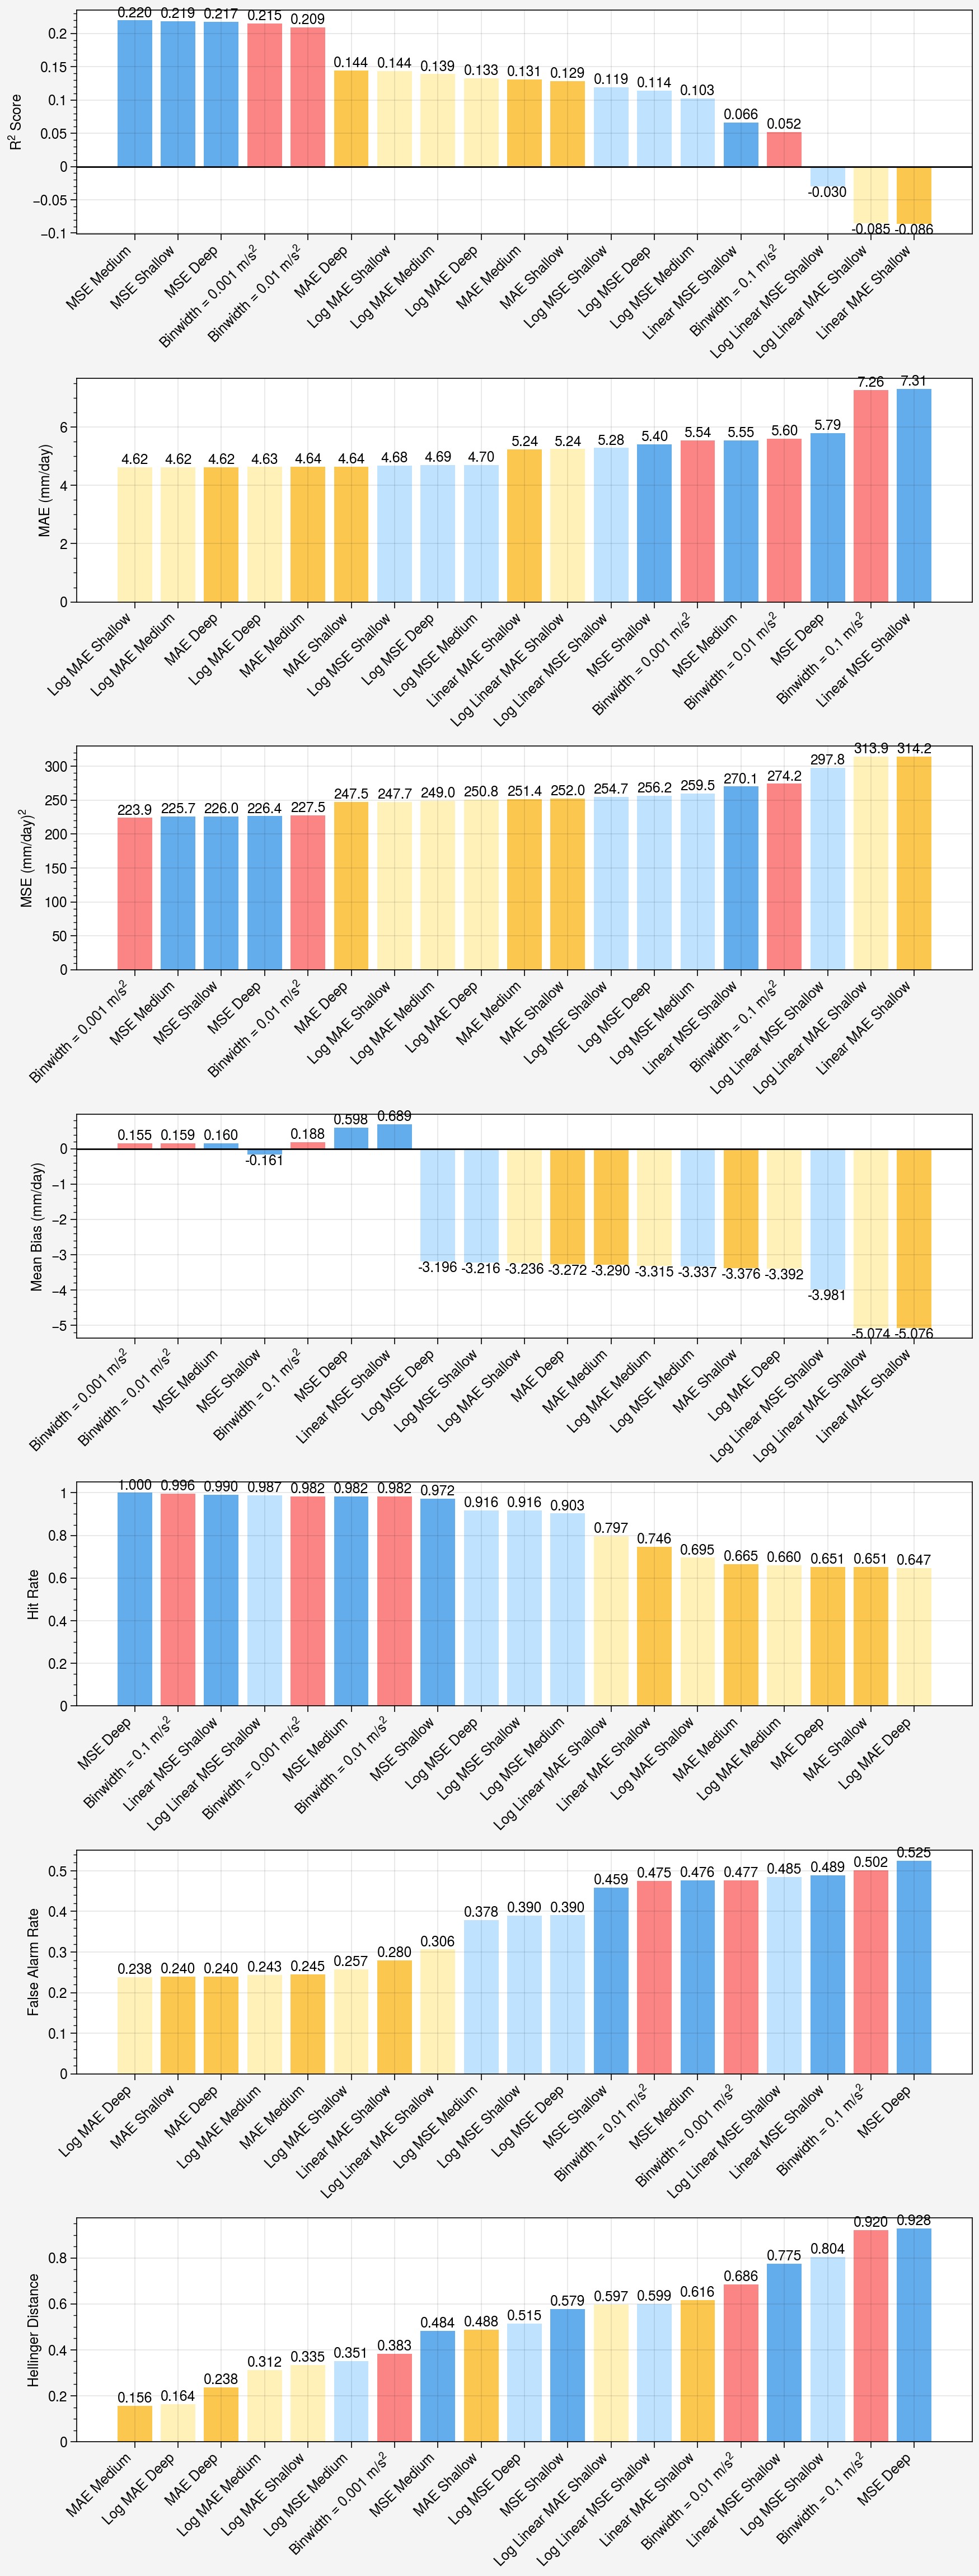

In [39]:
metricsconfig = {
    'r2': {'title':'R$^2$ Score','higher_better':True,'format':'.3f'},
    'mae':{'title':'MAE (mm/day)','higher_better':False,'format':'.2f'},
    'mse':{'title':'MSE (mm/day)$^2$','higher_better':False,'format':'.1f'},
    'bias':{'title':'Mean Bias (mm/day)','higher_better':None,'format':'.3f'},
    'hitrate':{'title':'Hit Rate','higher_better':True,'format':'.3f'},
    'far':{'title':'False Alarm Rate','higher_better':False,'format':'.3f'},
    'hellinger':{'title':'Hellinger Distance','higher_better': False,'format':'.3f'}}

ncols   = 1
nrows   = (len(metricsconfig)+ncols-1)//ncols
fig,axs = pplt.subplots(nrows=nrows,ncols=ncols,refwidth=8,refheight=2,share=False)

for i,(metric,config) in enumerate(metricsconfig.items()):
    row = i//ncols
    col = i%ncols
    if config['higher_better'] is True:
        sorteddf = metricsdf.sort_values(metric, ascending=False)
    elif config['higher_better'] is False:
        sorteddf = metricsdf.sort_values(metric, ascending=True)
    else:
        sorteddf = metricsdf.sort_values(metric, key=abs, ascending=True)
    
    colors = [get_model_color(name) for name in sorteddf['name']]
    bars = axs[row,col].bar(range(len(sorteddf)),sorteddf[metric],color=colors,alpha=0.7)
    axs[row,col].format(ylabel=config['title'],xminorticks='none')
    if metric=='r2' or metric=='bias':
        axs[row,col].axhline(y=0,color='k',linewidth=1)
    for j,(bar,value) in enumerate(zip(bars,sorteddf[metric])):
        height = bar.get_height()
        va   = 'bottom' if height>=0 else 'top'
        ypos = height if height>=0 else height
        axs[row,col].text(bar.get_x()+bar.get_width()/2.,ypos,f'{value:{config["format"]}}',ha='center',va=va)
    axs[row,col].set_xticks(range(len(sorteddf)))
    axs[row,col].set_xticklabels([d for d in sorteddf['description']],ha='right',rotation=45)

for i in range(len(metricsconfig),nrows*ncols):
    row = i//ncols
    col = i%ncols
    axs[row,col].axis('off')

pplt.show()

## Plot Pareto Front

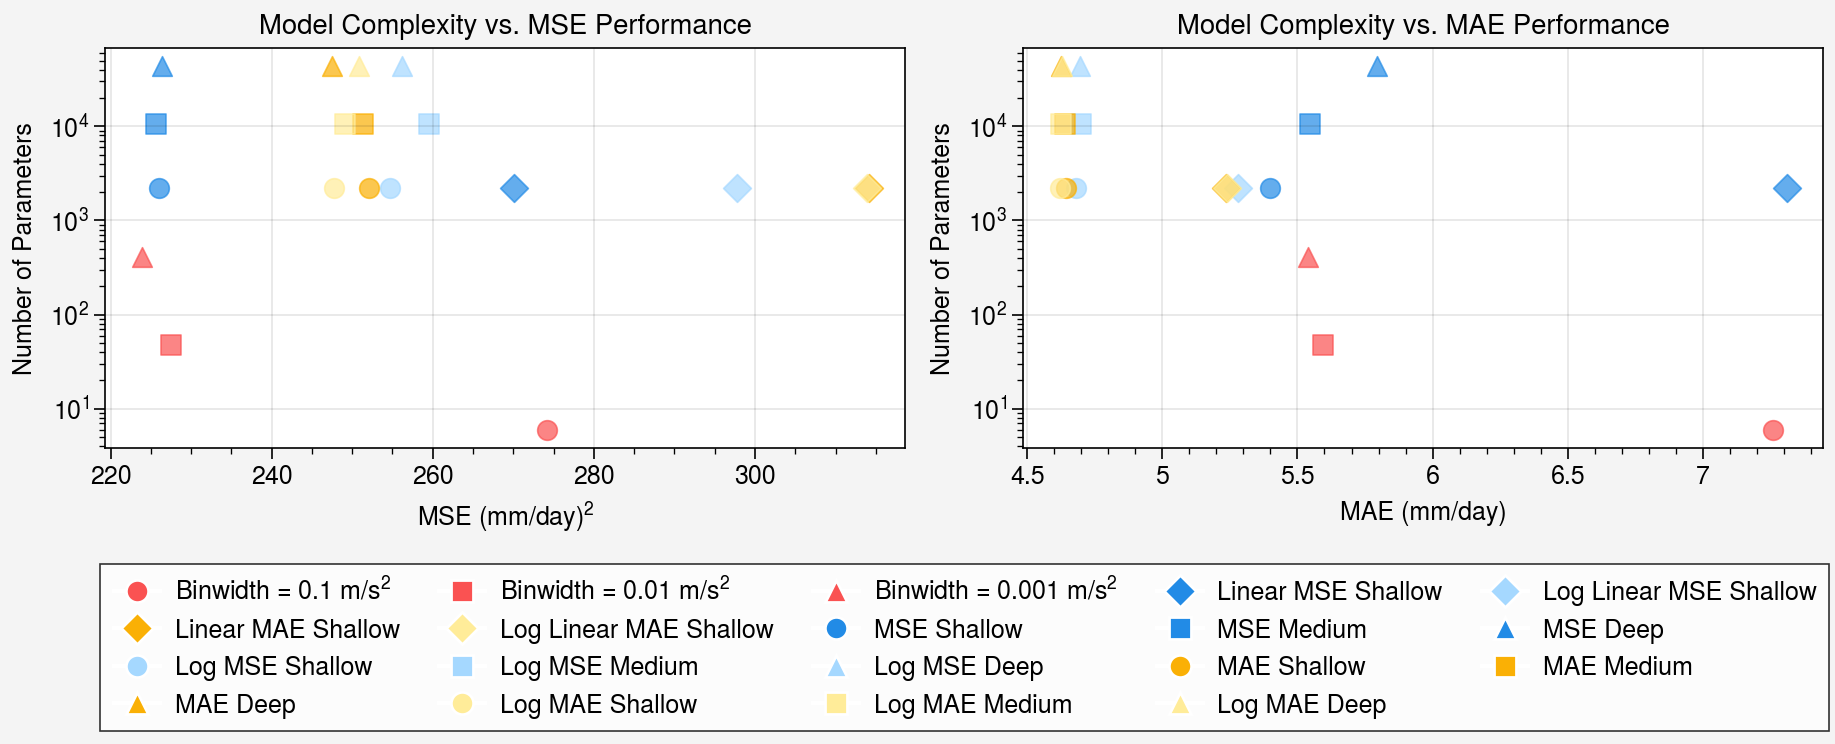

In [41]:
fig,axs = pplt.subplots(nrows=1,ncols=2,refwidth=4,refheight=2,share=False)

axs[0].format(title='Model Complexity vs. MSE Performance',
              xlabel='MSE (mm/day)$^2$',ylabel='Number of Parameters',yscale='log',yformatter='log')
axs[1].format(title='Model Complexity vs. MAE Performance',
              xlabel='MAE (mm/day)',ylabel='Number of Parameters',yscale='log',yformatter='log')

colors  = [get_model_color(name) for name in metricsdf['name']]
markers = [get_model_marker(name) for name in metricsdf['name']]

elements = []
for i,row in metricsdf.iterrows():
    axs[0].scatter(row['mse'],row['nparams'],color=colors[i], marker=markers[i], markersize=50, alpha=0.7)
    axs[1].scatter(row['mae'],row['nparams'],color=colors[i], marker=markers[i], markersize=50, alpha=0.7)
    elements.append(Line2D([0],[0],marker=markers[i],color='w',markerfacecolor=colors[i],markersize=8,label=row['description']))
fig.legend(handles=elements,loc='b',ncols=5)

pplt.show()